<a href="https://colab.research.google.com/github/yslama/STEMInequalities/blob/master/Inequalities_Yasmine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl https://www2.census.gov/programs-surveys/acs/data/pums/2017/1-Year/csv_pca.zip -O csv_pca.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71.4M    0 71.4M    0     0  32.2M      0 --:--:--  0:00:02 --:--:-- 32.2M
curl: (6) Could not resolve host: csv_pca.zip


In [0]:
! pip install scikit-plot
! pip install imblearn -U

Requirement already up-to-date: imblearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [0]:
! pip install shap

In [0]:
! unzip csv_pca.zip

Archive:  csv_pca.zip
replace psam_p06.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ACS2017_PUMS_README.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
# !pwd

/content


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
import sqlite3
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from pandas.io import sql
from matplotlib.ticker import ScalarFormatter
import time
import seaborn as sns
                                                           
from sklearn import preprocessing,model_selection           #crossval
from sklearn.model_selection import train_test_split                        #To create test and train datasets
import itertools                                                              #to iterate easier on objects
from xgboost import XGBClassifier                           #XGBoost classifier with sklearn wrapper               
import xgboost as xgb                                     #XGBoost package class
from sklearn                 import metrics                #Crossvalidation
from sklearn.metrics         import confusion_matrix                        #Classic CM
from sklearn.metrics         import accuracy_score,roc_auc_score,f1_score   #Relevant metrics
from sklearn.metrics         import roc_curve,precision_recall_curve        #Curves
from imblearn.over_sampling  import SMOTE                                   #SMOTE
import random as random
import shap

In [0]:
df = pd.read_csv('/content/psam_p06.csv')

In [0]:
df_duplicate = pd.read_csv('/content/psam_p06.csv')

In [0]:
df.shape

(377575, 286)

In [0]:
df.head()

RT       SERIALNO  DIVISION  SPORDER  ...  PWGTP77  PWGTP78  PWGTP79  PWGTP80
0  P  2017000000014         9        1  ...       62       68       17      101
1  P  2017000000014         9        2  ...       56       62       18       97
2  P  2017000000014         9        3  ...       60       60       16       90
3  P  2017000000017         9        1  ...       27      117       65      113
4  P  2017000000017         9        2  ...       25      110       72      123

[5 rows x 286 columns]

In [0]:
#SETTING GLOBAL PARAMETERS FOR PLT#############################################
plt.rcParams['figure.figsize'] = (12.0,4.0)
plt.rcParams.update({'font.size':10})
plt.rcParams['xtick.major.pad'] = '5'
plt.rcParams['ytick.major.pad'] = '5'
plt.style.use('ggplot')

### Recode Variables For Plotting And Interpretability

In [0]:
# recode sex variable
# First, change the integers that are used for coding.
# Right now, male = 1 and female = 2.
# to fit in a regression model they should be recoded to 0 and 1
if np.min(df['SEX']) > 0: #ensures that code won't be run if it's been recoded already
  df['SEX'] = df['SEX'] - 1
# Next, create a new column with Male/Female labels
oldNewMap = {0: "Male", 1: "Female"}
df['sex_recode'] = df['SEX'].map(oldNewMap)

In [0]:
# Recode race
# All individuals of Hispanic origin will be categorized as Hispanic.
# Non-Hispanic White, Non-Hispanic Black and Asian will be included as categories.
# All other races are coded as "Other"
def race_recode(row):
  if row['HISP'] > 1:
    return "Hispanic"
  elif row['RAC1P'] == 1:
    return "White"
  elif row['RAC1P'] == 2:
    return "Black"
  elif row['RAC1P'] == 6:
    return "Asian"
  else:
    return "Other"
df['race_recode'] = df.apply(race_recode, axis=1)

# recode hispanic origin into 7 categories
oldNewMap = {1: "Not Spanish/Hispanic/Latino", 2: "Mexican", 3: "Puerto_Rican", 4: "Cuban", 
            5: "Other_Central_American", 6: "Other_Central_American", 7: "Other_Central_merican", 
            8: "Other_Central_American", 9: "Other_Central_American", 10: "Other_Central_American", 
            11: "Other_Central_American", 12: "Other_Central_American", 13: "South_American",
            14: "South_American", 15: "South_American", 16: "South_American", 17: "South_American", 
            18: "South_American", 19: "South_American", 20: "South_American", 21: "South_American", 
            22: "South_American", 23: "Spaniard", 24: "All_Other_Hispanic"}       
df['hisp_recode'] = df['HISP'].map(oldNewMap)

# recode the HISP variable for easy readability
oldNewMap = {1: "Not Spanish/Hispanic/Latino", 2: "Mexican", 3: "Puerto Rican", 4: "Cuban", 
             5: "Dominican", 6: "Costa Rican", 7: "Guatemalan", 8: "Honduran", 9: "Nicaraguan",
            10: "Panamanian", 11: "Salvadorian", 12: "Other Central American", 13: "Argentinian",
            14: "Bolivian", 15: "Chilean", 16: "Colombian", 17: "Ecuadorian", 18: "Paraguayan",
            19: "Peruvian", 20: "Uruguayan", 21: "Venezuelan", 22: "Other South American",
            23: "Spaniard", 24: "All Other Spanish/Hispanic/Latino"}
df['detailed_hispanic_origin'] = df['HISP'].map(oldNewMap)

In [0]:
df.head()
df['RAC1P']

0         9
1         9
2         9
3         6
4         6
         ..
377570    1
377571    1
377572    8
377573    8
377574    1
Name: RAC1P, Length: 377575, dtype: int64

In [0]:
df['SFR'] = df['SFR'].fillna(0)  
df['YOEP'] = df['YOEP'].fillna(0)  
df['DECADE'] = df['DECADE'].fillna(0)  
df['ESP'] = df['ESP'].fillna(0)  
df['CITWP'] = df['CITWP'].fillna(0)  

df = df.drop(['RAC1P'], axis=1)
df = df.drop(['HISP'], axis=1)

In [0]:
# Create STEM degree outcome variable
oldNewMap = {1: 1, 2: 0}
df['science_degree'] = df['SCIENGP'].map(oldNewMap)
df['science_degree'].fillna(value=0,inplace=True) # map doesn't include NA values, so they must be filled with zeroes

# Create STEM occupation outcome variable
science_job_codes = ['113021','119041','119121','151111','151121','151122','151131','151132','151133',
                          '151134','151141','151142','151143','151151','151152','151199','152011','152021',
                          '152031','152041','152099','171021','171022','172011','172021','172031','172041',
                          '172051','172061','172071','172072','172081','172111','172112','172121','172131',
                          '172141','172151','172161','172171','172199','173012','173013','173019','173021',
                          '173022','173023','173024','173025','173026','173027','173029','173031','191011',
                          '191012','191012','191021','191022','191023','191029','191031','191032','191041',
                          '191042','191099','192011','192012','192021','192031','192032','192041','192042',
                          '192043','192099','194011','194021','194031','194041','194051','194091','194092',
                          '194093','251021','251022','251032','251041','251042','251043','251051','251052',
                          '251053','251054','414011','419031']
df['science_occupation'] = df['SOCP'].isin(science_job_codes).astype(int)
df = df.drop(['SCIENGP'], axis=1)

In [0]:
df.shape

(377575, 289)

### Plots

People with STEM degrees are 11.253658213599946% out of 377575 observations


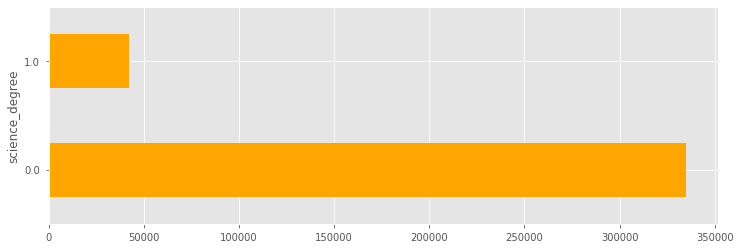

In [0]:
fig = plt.figure()
d1 = df.groupby(['science_degree']).size()                    #We group by default observation

print("People with STEM degrees are {}% out of {} observations".format(100* d1[1]/(d1[1]+d1[0]), d1[1]+d1[0]))
p = d1.plot(kind='barh', color='orange')

plt.show()

People with STEM jobs are 1.9437197907700456% out of 377575 observations


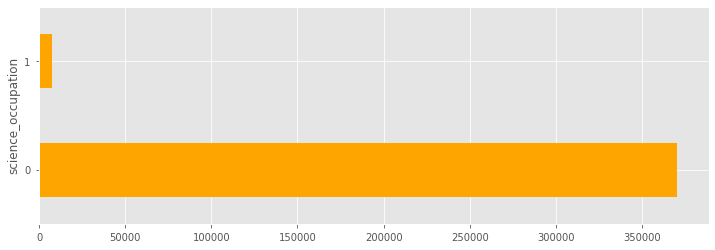

In [0]:
fig = plt.figure()
d1 = df.groupby(['science_occupation']).size()                    #We group by default observation

print("People with STEM jobs are {}% out of {} observations".format(100* d1[1]/(d1[1]+d1[0]), d1[1]+d1[0]))
p = d1.plot(kind='barh', color='orange')

plt.show()

In [0]:
# converted_categories = list(df.select_dtypes(include = 'category').columns.values)

# i = 0
# for each in converted_categories:
#     d = df.groupby(['science_degree', each]).size()
#     p = d.unstack(level=1).plot(kind='bar')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()
#     i += 1

In [0]:
# i = 0
# for each in converted_categories:
#     d = df.groupby(['science_occupation', each]).size()
#     p = d.unstack(level=1).plot(kind='bar')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()
#     i += 1

### Drop Useless Variables

In [0]:
#drop useless variables
df = df.drop(['ADJINC','SERIALNO','SPORDER','PUMA', 'SCHG','JWDP','RT','DIVISION', 'ST', 'NWRE', 'MIGPUMA', 'SFN', 'FINDP', 'FOCCP', 
         'SCHL','PWGTP2','PWGTP3','PWGTP4','PWGTP5','PWGTP6','PWGTP7','PWGTP8', 'PWGTP1', 'OCCP', 'JWAP', 'JWDP', 'NAICSP',  
         'PWGTP9','PWGTP10','PWGTP11','PWGTP12','PWGTP13','PWGTP14','PWGTP15','PWGTP16','PWGTP17','PWGTP18','PWGTP19',
         'PWGTP20','PWGTP21','PWGTP22','PWGTP23','PWGTP24','PWGTP25','PWGTP26','PWGTP27','PWGTP28','PWGTP29','PWGTP30',
         'PWGTP31','PWGTP32','PWGTP33','PWGTP34','PWGTP35','PWGTP36','PWGTP37','PWGTP38','PWGTP39','PWGTP40','PWGTP41',
         'PWGTP42','PWGTP43','PWGTP44','PWGTP45','PWGTP46','PWGTP47','PWGTP48','PWGTP49','PWGTP50','PWGTP51','PWGTP52',
         'PWGTP53','PWGTP54','PWGTP55','PWGTP56','PWGTP57','PWGTP58','PWGTP59','PWGTP60','PWGTP61','PWGTP62','PWGTP63',
         'PWGTP64','PWGTP65','PWGTP66','PWGTP67','PWGTP68','PWGTP69','PWGTP70','PWGTP71','PWGTP72','PWGTP73','PWGTP74',
         'PWGTP75','PWGTP76','PWGTP77','PWGTP78','PWGTP79','PWGTP80'], axis = 1)

In [0]:
df.shape

(377575, 191)

### Drop observations for people who have never worked, or haven't worked in 5 years

In [0]:
df.dropna(subset=['SOCP'], how='all', inplace=True)

In [0]:
df.shape

(220772, 191)

In [0]:
 df = df.drop('SOCP', axis=1)

### Dealing With Missing Values

In [0]:
#DEALING WITH MISSING VALUES
c = df.isnull().sum()
c = c/len(df.index)
num = 0
for i,v in c.items():
    if v * 100 > 25:
        num += 1
        df = df.drop([i], axis = 1)
        #print('index: ', i,' value: ', v*100)
print('Number of variables with more than 25% missing values: ', num)

Number of variables with more than 25% missing values:  34


In [0]:
df.shape

(220772, 156)

In [0]:
df_copy = df.copy(deep=True)

### Replace all remaining NAN with 0


In [0]:
df.fillna(0)

REGION  PWGTP  ...  science_degree  science_occupation
0            4     59  ...             0.0                   0
1            4     57  ...             0.0                   0
3            4     75  ...             1.0                   1
4            4     71  ...             1.0                   0
7            4     63  ...             0.0                   0
...        ...    ...  ...             ...                 ...
377565       4     84  ...             0.0                   0
377567       4     81  ...             0.0                   0
377568       4     33  ...             0.0                   0
377569       4     93  ...             0.0                   0
377571       4     28  ...             0.0                   0

[220772 rows x 156 columns]

### Drop any observations with na

In [0]:
# #drop any observations with na
# df_lr = df_copy.copy(deep=True)
# df_lr.dropna(inplace=True)
# df_lr = df_lr.reset_index(drop = True)

In [0]:
df_lr = df_copy.copy(deep=True)
df_lr = df_lr.reset_index(drop = True)

In [0]:
df_lr.shape

(220772, 156)

In [0]:
categoryva=['PWGTP','AGEP','INTP','OIP','RETP','SEMP', 'SEX', 'science_occupation', 'PINCP',
            'science_degree']  # non categorical features

### Replace the least commonly used categories within each column by -99 to reduce the number of categories

In [0]:
top_k_cat_vals_per_col = {}
for col in df_lr.drop(columns=categoryva).columns:
  top_k_cat_vals_per_col[col] = set(df_lr[col].value_counts().sort_values().index[-10:].tolist())
  df_lr[col] = df_lr[col].map(lambda val: val if val in top_k_cat_vals_per_col[col] else -99)

In [0]:
# top_k_cat_vals_pobp = df_duplicate['POBP'].value_counts().sort_values().index[-10:].tolist()
# top_k_cat_vals_pobp

[312, 210, 17, 48, 247, 36, 207, 233, 303, 6]

In [0]:
# top_k_cat_vals_anc1p = df_duplicate['ANC1P'].value_counts().sort_values().index[-10:].tolist()
# top_k_cat_vals_anc1p

[211, 902, 720, 924, 22, 706, 50, 32, 999, 210]

In [0]:
# top_k_cat_vals_indp = df_duplicate['INDP'].value_counts().sort_values().index[-10:].tolist()
# top_k_cat_vals_indp

[8590.0, 9470.0, 8370.0, 7070.0, 7380.0, 7870.0, 8190.0, 770.0, 7860.0, 8680.0]

In [0]:
df.head()

REGION  PWGTP  ...  science_degree  science_occupation
0       4     59  ...             0.0                   0
1       4     57  ...             0.0                   0
3       4     75  ...             1.0                   1
4       4     71  ...             1.0                   0
7       4     63  ...             0.0                   0

[5 rows x 156 columns]

In [0]:
#convert qualitative data to category
cat_features = list(df_lr.select_dtypes(include = 'object').columns.values)
for i in cat_features:
     df_lr[i] = df_lr[i].astype('category')

df_lr[df_lr.columns.difference(categoryva)]= df_lr[df_lr.columns.difference(categoryva)].astype('category')
print("Explanatory variables in set:  {}".format(len(df_lr.columns)-1))

Explanatory variables in set:  155


In [0]:
df.head()

REGION  PWGTP  ...  science_degree  science_occupation
0       4     59  ...             0.0                   0
1       4     57  ...             0.0                   0
3       4     75  ...             1.0                   1
4       4     71  ...             1.0                   0
7       4     63  ...             0.0                   0

[5 rows x 156 columns]

### Get dummy variables for all categorical features

In [0]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer 

In [0]:
#to_conv_cols = ['detailed_hispanic_origin', 'hisp_recode', 'race_recode', 'sex_recode', 'SOCP', 'NAICSP']
#mapper = {col: dict(zip(df_lr[col].unique(), range(len(df_lr[col].unique())))) for col in to_conv_cols}
#for col in to_conv_cols:
#  df_lr[col] = df_lr[col].map(mapper[col])

In [0]:
df_lr = pd.get_dummies(df_lr, columns=df_lr.columns.difference(categoryva))

In [0]:
# one_hot_cols = df_lr.columns.difference(categoryva)
# one_hot_order = {col: df_lr[col].unique().tolist() for col in one_hot_cols}

In [0]:
df_lr.shape

(220772, 564)

In [0]:
# Create correlation matrix
corr_matrix = df_lr.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
print(to_drop)
print(corr_matrix);
df_lr = df_lr.drop(to_drop, axis = 1)
print("Explanatory variables in set:  {}".format(len(df_lr.columns)-1))

['ANC_2', 'ANC1P_999', 'ANC2P_999', 'CITWP_-99.0', 'CITWP_0.0', 'DDRS_2.0', 'DEAR_2', 'DECADE_0.0', 'DEYE_2', 'DIS_2', 'DOUT_2.0', 'DPHY_2.0', 'DREM_2.0', 'ESR_6.0', 'FAGEP_1', 'FCITP_1', 'FCITWP_1', 'FCOWP_1', 'FDDRSP_0', 'FDDRSP_1', 'FDEARP_0', 'FDEARP_1', 'FDEYEP_0', 'FDEYEP_1', 'FDISP_0', 'FDISP_1', 'FDOUTP_0', 'FDOUTP_1', 'FDPHYP_0', 'FDPHYP_1', 'FDRATP_1', 'FDRATXP_1', 'FDREMP_0', 'FDREMP_1', 'FENGP_1', 'FESRP_0', 'FESRP_1', 'FFERP_1', 'FFODP_1', 'FGCLP_1', 'FGCMP_1', 'FGCRP_1', 'FHICOVP_1', 'FHINS1P_0', 'FHINS1P_1', 'FHINS2P_0', 'FHINS2P_1', 'FHINS3P_0', 'FHINS3P_1', 'FHINS4P_0', 'FHINS4P_1', 'FHINS5P_0', 'FHINS5P_1', 'FHINS6P_0', 'FHINS6P_1', 'FHINS7P_0', 'FHINS7P_1', 'FHISP_1', 'FINTP_1', 'FJWDP_1', 'FJWMNP_0', 'FJWMNP_1', 'FJWRIP_0', 'FJWRIP_1', 'FJWTRP_0', 'FJWTRP_1', 'FLANP_0', 'FLANP_1', 'FLANXP_0', 'FLANXP_1', 'FMARHDP_1', 'FMARHMP_0', 'FMARHMP_1', 'FMARHTP_0', 'FMARHTP_1', 'FMARHWP_0', 'FMARHWP_1', 'FMARHYP_1', 'FMARP_1', 'FMIGP_0', 'FMIGP_1', 'FMIGSP_1', 'FMILPP_0', 'FM

In [0]:
# dflrbefore = df_lr.copy(deep=True)

In [0]:
df_lr = df_lr.reset_index(drop = True)

y_lr = df_lr['science_occupation']
X_lr = df_lr.drop(['science_degree','science_occupation'], axis = 1)

### Split the Data

Without SMOTE

In [0]:
target = 'science_occupation'
predictors = list(df_lr.columns.values)
predictors.remove(target)
predictors.remove('science_degree')

In [0]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=288)

In [0]:
sum(test_y_lr==0)

63981

In [0]:
len(test_y_lr)

66232


With SMOTE

In [0]:
train_df_lr = pd.DataFrame(train_X_lr[predictors], columns = predictors)
train_df_lr[target] = train_y_lr

29.373427672955973


In [0]:
scale = train_df_lr[train_df_lr.science_occupation == 0].shape[0]/train_df_lr[train_df_lr.science_occupation\
                                                                              == 1].shape[0]
print(scale)

29.373427672955973


In [0]:
#SMOTE#########################################################################
from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio = 1.0, random_state=288)

train_X_res, train_y_res = sm.fit_sample(train_X_lr, train_y_lr)
print("length of oversampled data is ",len(train_X_res))
print("Number of no science_occupation in oversampled data",len(train_y_res[train_y_res==0]))
print("Number of science_occupation",len(train_y_res[train_y_res==1]))
print("Proportion of no science_occupation data in oversampled data is ",len(train_y_res[train_y_res==0])/len(train_X_res))
print("Proportion of science_occupation data in oversampled data is ",len(train_y_res[train_y_res==1])/len(train_X_res))

length of oversampled data is  298904
Number of no science_occupation in oversampled data 149452
Number of science_occupation 149452
Proportion of no science_occupation data in oversampled data is  0.5
Proportion of science_occupation data in oversampled data is  0.5


In [0]:
train_df_lr_res = pd.DataFrame(train_X_res, columns = predictors)
train_df_lr_res[target] = train_y_res

### MODELS

In [0]:
#HELPER FUNCTIONS##############################################################

#Helper function 1: Fit the model to data using the AUC as a metric, showing iterations and printing a report

"""
*NOTE: 
This functions takes an XGBClassifier Object as input (with all the parameters and hyperparameters predefined) and will
only perform crossvalidation to better the chosen metric. AUC is used here but we can change it later. It also needs a 
predictors string list. Other parameters are optional.
"""

def modelfit(alg, dtrain, predictors, eval_set, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['logloss','auc'], early_stopping_rounds=early_stopping_rounds, verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric = ['auc','logloss'], eval_set=eval_set)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [0]:
#Helper function 2: This one plots a nice looking confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [0]:
#Helper function 3: This one gets the precision, recall and fallout curves given data, target and parameters

def get_curves(X_, y_, pars):
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 0.2)
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec

#Helper function 4: This one generates the curves

def gen_curves(X_, y_, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_, y_, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

#Helper function 5: This one plots the curves using the functions defined above

def plot_roc(X_, y_, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,14));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_, y_, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.6, 0.85])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.75, 0.95])
    plt.show()
    
from sklearn.metrics import classification_report



### LOGISTIC REGRESSION

Model 1 - Without SMOTE

In [0]:
# fit a logistic regression model and store the class predictions
from sklearn.linear_model import LogisticRegressionCV

model_lr = LogisticRegressionCV(class_weight='balanced',cv=3, random_state=288)
model_lr.fit(train_X_lr, train_y_lr)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=288, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
f1_score(model_lr.predict(test_X_lr), test_y_lr)

0.16252922186351998

In [0]:
# sorted((model_lr.coef_[0]))[-15::]

In [0]:
# #Significant Features
# coefs=model_lr.coef_[0]
# top_10 = np.argpartition(coefs, -15)[-15:]
# top_10_sorted=top_10[np.argsort(coefs[top_10])]
# print(train_X_lr.columns[top_10_sorted])

In [0]:
# y_proba = model_lr.predict_proba(test_X_lr)
# y_pred = model_lr.predict(test_X_lr)

# predictions = [round(value) for value in y_pred] #predctions vector

# #We create a new dataframe with the predicted classes, probas of default and real values
# yout = pd.DataFrame(columns = ['classe', 'Probability'])
# yout['classe'] = pd.Series(y_pred)
# yout['Probability'] = pd.Series(y_proba[:,1])
# test = test_y_lr.copy(deep = True)
# yout['test'] = test.reset_index(drop = True)

In [0]:
# import scikitplot as skplt

# skplt.metrics.plot_roc(yout.test, y_proba)
# skplt.metrics.plot_precision_recall(yout.test, y_proba)

In [0]:
# skplt.metrics.plot_confusion_matrix(test_y_lr, predictions, normalize=False)

# plt.show()

Model 2 - With SMOTE

In [0]:
model_lr2 = LogisticRegressionCV(class_weight='balanced',cv=3, random_state=288)
model_lr2.fit(train_df_lr_res[predictors], train_df_lr_res[target])

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=288, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
f1_score(model_lr2.predict(test_X_lr), test_y_lr)

0.15330387205387205

## Features

In [0]:
sorted((model_lr.coef_[0]))[-15::]

[0.009501566624107755,
 0.009718697329233238,
 0.00997639293744858,
 0.012249410450010639,
 0.01389197847152806,
 0.014015508645019648,
 0.015563046137690079,
 0.016923601708618848,
 0.01836945054917699,
 0.01869838706744907,
 0.03417711843897875,
 0.036181199288230825,
 0.03873975165094221,
 0.03925506195239396,
 0.05885905254249151]

In [0]:
#Significant Features
coefs=model_lr.coef_[0]
top_10 = np.argpartition(coefs, -15)[-15:]
top_10_sorted=top_10[np.argsort(coefs[top_10])]
print(train_X_lr.columns[top_10_sorted])

Index(['INDP_7870.0', 'CIT_4', 'POWPUMA_6700.0', 'DECADE_8.0', 'POBP_210',
       'MAR_1', 'COW_4.0', 'ANC1P_706', 'race_recode_White', 'ANC1P_-99',
       'RELP_0', 'WKHP_40.0', 'POBP_-99', 'HINS1_1', 'INDP_7380.0'],
      dtype='object')


## Metrics

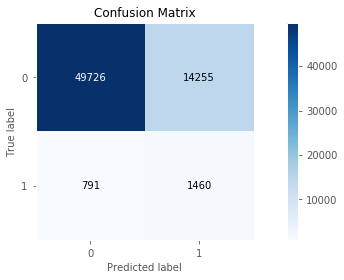

In [0]:
import scikitplot as skplt

y_proba = model_lr.predict_proba(test_X_lr)
y_pred = model_lr.predict(test_X_lr)

predictions_lr = [round(value) for value in y_pred] #predctions vector

#We create a new dataframe with the predicted classes, probas of default and real values

yout = pd.DataFrame(columns = ['classe', 'Probability'])
yout['classe'] = pd.Series(y_pred)
yout['Probability'] = pd.Series(y_proba[:,1])
test = test_y_lr.copy(deep = True)
yout['test'] = test.reset_index(drop = True)

skplt.metrics.plot_confusion_matrix(test_y_lr, predictions_lr, normalize=False)

plt.show()

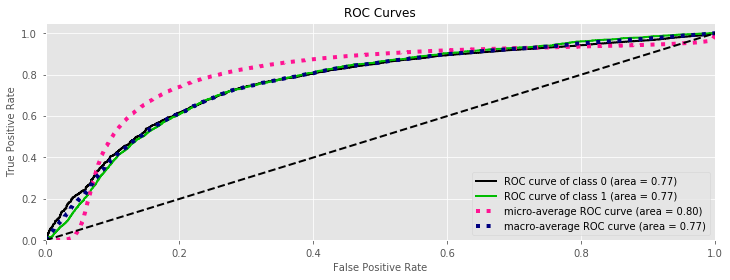

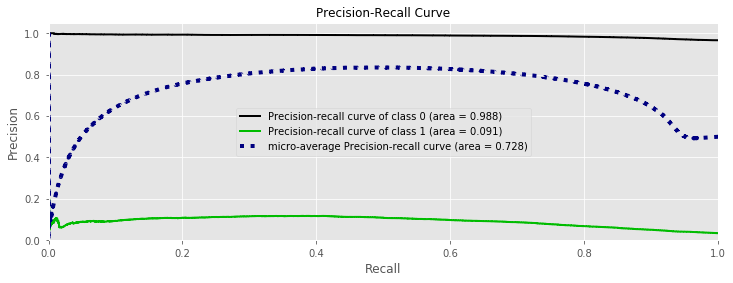

In [0]:
skplt.metrics.plot_roc(yout.test, y_proba)
skplt.metrics.plot_precision_recall(yout.test, y_proba)

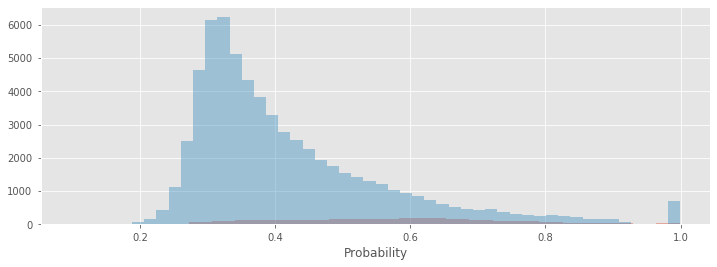

In [0]:
sns.distplot(yout[yout.test == 1].Probability, kde = False)
sns.distplot(yout[yout.test == 0].Probability, kde = False)
plt.show()

In [0]:
# Create a new blank dataframe for predictions
predict_df = pd.DataFrame(test_X_lr[predictors],columns=predictors)

# predict outcome for each combination

predict_df['occ_predict'] = yout.Probability

In [0]:
%matplotlib inline
# Plot predicted probas for STEM Occupations
sex_age_chart_occ = predict_df.pivot_table(index='AGEP',values='occ_predict',columns='SEX',aggfunc="mean")
sex_age_chart_occ.columns = ['Male','Female']
sex_age_chart_occ.index.name = 'Age'
sex_age_chart_occ.plot(title='Predicted Probability for STEM Occupation')
plt.ylim(0,1.0)
plt.show()

In [0]:
sex_age_chart_occ.head()

### RANDOM FORESTS

In [0]:
from sklearn.ensemble import RandomForestClassifier


In [0]:
# # ORIGINAL
# from sklearn.ensemble import RandomForestClassifier

# model_rf = RandomForestClassifier(verbose=2, n_jobs = -1, n_estimators=1000)

# random.seed(a=288, version=2)
# model_rf.fit(train_df_lr_res[predictors], train_df_lr_res[target])
# model_rf;

In [0]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 5)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = list(range(10, 60, 10))

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth}

In [0]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=5, bootstrap=True)

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=288, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(train_df_lr[predictors], train_df_lr[target])

In [0]:
# rf_random.best_params_

In [0]:
# from sklearn.model_selection import GridSearchCV

# # Create the parameter grid 
# param_grid = {
#     'max_depth': [5, 10, 20, 50],
#     'max_features': [5, 10],
#     'n_estimators': [100, 200, 500]
# }
# # First create the base model to tune
# rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=5)

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [0]:
# grid_search.fit(train_df_lr[predictors], train_df_lr[target])

In [0]:
# best_grid = grid_search.best_params_
# best_grid

In [0]:
# model_rf = grid_search.best_estimator_

In [0]:
model_rf = RandomForestClassifier(max_depth=6, class_weight='balanced', min_samples_split = 5, n_estimators=500, random_state=288)
model_rf.fit(train_df_lr_res[predictors], train_df_lr_res[target])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=288, verbose=0, warm_start=False)

In [0]:
f1_score(model_rf.predict(test_X_lr), test_y_lr)

0.21118627289226202

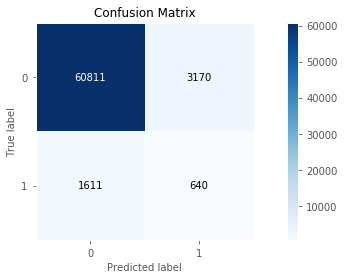

In [0]:
y_proba = model_rf.predict_proba(test_X_lr)
y_pred = model_rf.predict(test_X_lr)

predictions_rf = [round(value) for value in y_pred] #predctions vector

#We create a new dataframe with the predicted classes, probas of default and real values

yout_rf = pd.DataFrame(columns = ['classe', 'Probability'])
yout_rf['classe'] = pd.Series(y_pred)
yout_rf['Probability'] = pd.Series(y_proba[:,1])
test = test_y_lr.copy(deep = True)
yout_rf['test'] = test.reset_index(drop = True)

skplt.metrics.plot_confusion_matrix(test_y_lr, predictions_rf, normalize=False)

plt.show()

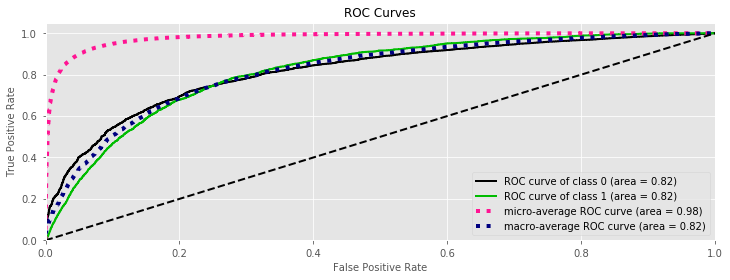

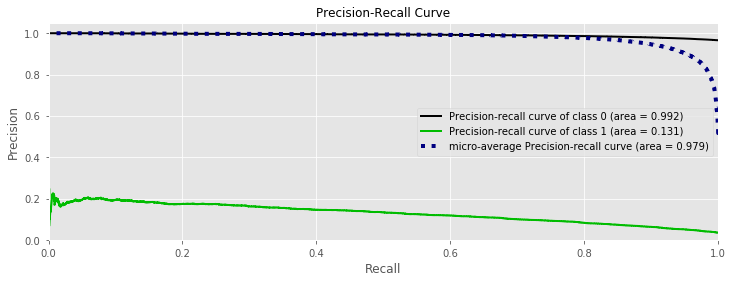

In [0]:
skplt.metrics.plot_roc(yout_rf.test, y_proba)
skplt.metrics.plot_precision_recall(yout_rf.test, y_proba)

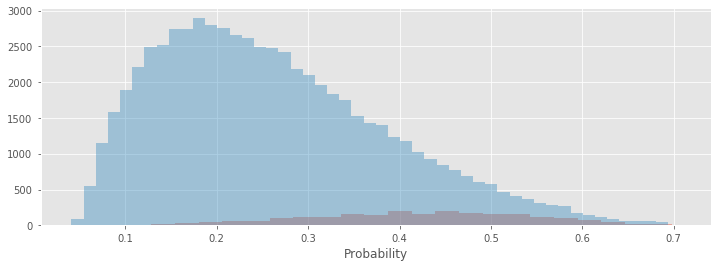

In [0]:
sns.distplot(yout_rf[yout_rf.test == 1].Probability, kde = False)
sns.distplot(yout_rf[yout_rf.test == 0].Probability, kde = False)
plt.show()

In [0]:
# from sklearn.tree import _tree


# def leaf_depths(tree, node_id = 0):
    
#     left_child = tree.children_left[node_id]
#     right_child = tree.children_right[node_id]

#     if left_child == _tree.TREE_LEAF:
        
#         depths = np.array([0])

#     else:
        
#         left_depths = leaf_depths(tree, left_child) + 1
#         right_depths = leaf_depths(tree, right_child) + 1

#         depths = np.append(left_depths, right_depths)

#     return depths

# def leaf_samples(tree, node_id = 0):
    
#     left_child = tree.children_left[node_id]
#     right_child = tree.children_right[node_id]

#     if left_child == _tree.TREE_LEAF:
        
#         samples = np.array([tree.n_node_samples[node_id]])

#     else:
        
#         left_samples = leaf_samples(tree, left_child)
#         right_samples = leaf_samples(tree, right_child)

#         samples = np.append(left_samples, right_samples)

#     return samples

# def draw_tree(ensemble, tree_id=0):

#     plt.figure(figsize=(8,8))
#     plt.subplot(211)

#     tree = ensemble.estimators_[tree_id].tree_

#     depths = leaf_depths(tree)
#     plt.hist(depths, histtype='step', color='#9933ff', 
#              bins=range(min(depths), max(depths)+1))

#     plt.xlabel("Depth of leaf nodes (tree %s)" % tree_id)
    
#     plt.subplot(212)
    
#     samples = leaf_samples(tree)
#     plt.hist(samples, histtype='step', color='#3399ff', 
#              bins=range(min(samples), max(samples)+1))
    
#     plt.xlabel("Number of samples in leaf nodes (tree %s)" % tree_id)
    
#     plt.show()

# def draw_ensemble(ensemble):

#     plt.figure(figsize=(8,8))
#     plt.subplot(211)

#     depths_all = np.array([], dtype=int)

#     for x in ensemble.estimators_:
#         tree = x.tree_
#         depths = leaf_depths(tree)
#         depths_all = np.append(depths_all, depths)
#         plt.hist(depths, histtype='step', color='#ddaaff', 
#                  bins=range(min(depths), max(depths)+1))

#     plt.hist(depths_all, histtype='step', color='#9933ff', 
#              bins=range(min(depths_all), max(depths_all)+1), 
#              weights=np.ones(len(depths_all))/len(ensemble.estimators_), 
#              linewidth=2)
#     plt.xlabel("Depth of leaf nodes")
    
#     samples_all = np.array([], dtype=int)
    
#     plt.subplot(212)
    
#     for x in ensemble.estimators_:
#         tree = x.tree_
#         samples = leaf_samples(tree)
#         samples_all = np.append(samples_all, samples)
#         plt.hist(samples, histtype='step', color='#aaddff', 
#                  bins=range(min(samples), max(samples)+1))
    
#     plt.hist(samples_all, histtype='step', color='#3399ff', 
#              bins=range(min(samples_all), max(samples_all)+1), 
#              weights=np.ones(len(samples_all))/len(ensemble.estimators_), 
#              linewidth=2)
#     plt.xlabel("Number of samples in leaf nodes")
    
#     plt.show()

In [0]:
# draw_ensemble(model_rf)

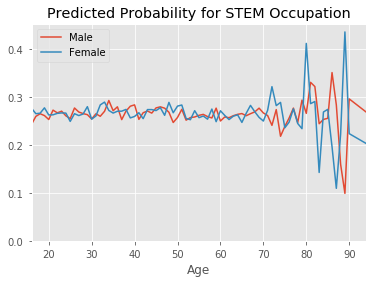

In [0]:
# Create a new blank dataframe for predictions
predict_df = pd.DataFrame(test_X_lr[predictors],columns=predictors)

# predict outcome for each combination

predict_df['occ_predict'] = yout_rf.Probability

%matplotlib inline
# Plot predicted probas for STEM Occupations
sex_age_chart_occ = predict_df.pivot_table(index='AGEP',values='occ_predict',columns='SEX',aggfunc="mean")
sex_age_chart_occ.columns = ['Male','Female']
sex_age_chart_occ.index.name = 'Age'
sex_age_chart_occ.plot(title='Predicted Probability for STEM Occupation')
plt.ylim(0)
plt.show()

In [0]:
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_xgb_2)
shap_values = explainer.shap_values(test_X_lr)

# visualize the first 100 prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[:100,:], test_X_lr.iloc[:100,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


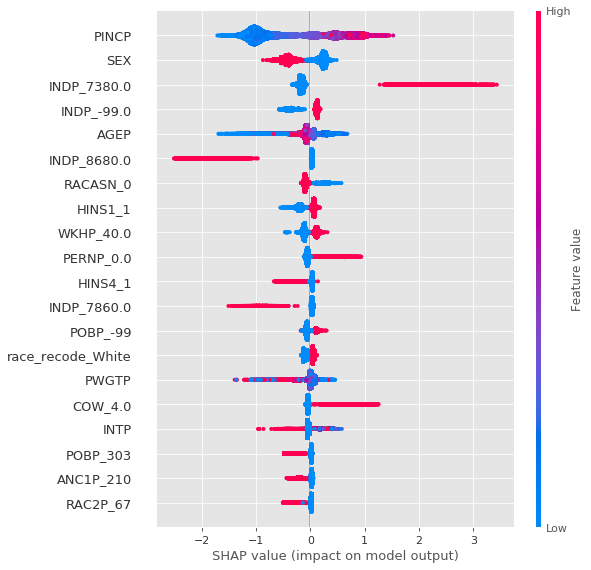

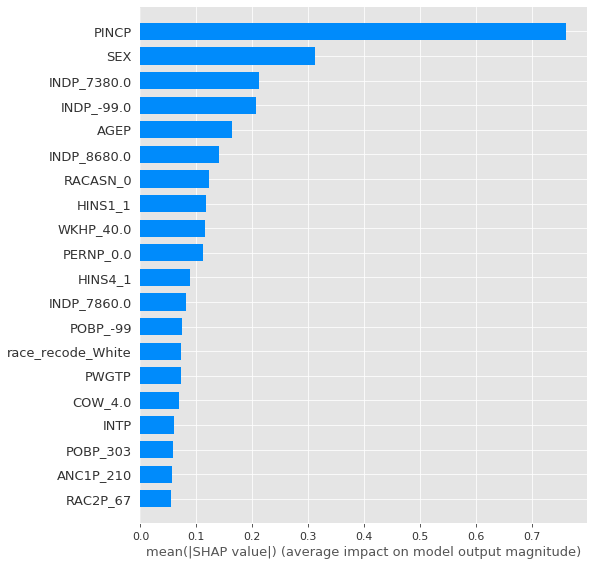

In [0]:
shap.summary_plot(shap_values, test_X_lr)
shap.summary_plot(shap_values, test_X_lr, plot_type='bar')

In [0]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X_lr.iloc[0,:])

## XGBoost

In [0]:
#use xgboost 
target = 'science_occupation'
def modelfit(alg, dtrain, predictors, eval_set, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['logloss','auc'], early_stopping_rounds=early_stopping_rounds, verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric = ['auc','logloss'], eval_set=eval_set)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    print(feat_imp)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Model 1

Normal XGB without SMOTE and Without Reweighting

In [0]:
model_xgb_1 = XGBClassifier()
model_xgb_1.fit(train_X_lr, train_y_lr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
f1_score(model_xgb_1.predict(test_X_lr), test_y_lr)

0.00617828773168579

### Model 2

Reweighted XGB without SMOTE

In [0]:
scale_weight= 1/np.mean(train_y_lr)
scale_weight

30.373427672955977

In [0]:
model_xgb_2 = XGBClassifier(scale_pos_weight=scale_weight, gamma=3, n_estimators=500)
model_xgb_2.fit(train_X_lr, train_y_lr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=30.373427672955977,
              seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
f1_score(model_xgb_2.predict(test_X_lr), test_y_lr)

0.20365358592692828

Performance Metrics

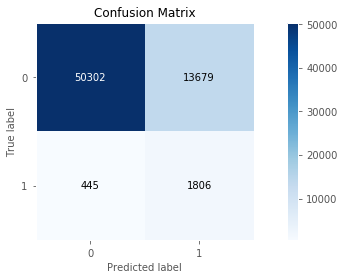

In [0]:
y_proba = model_xgb_2.predict_proba(test_X_lr)
y_pred = model_xgb_2.predict(test_X_lr)

# predictions = [(value > 0.5)  for value in y_pred] #predctions vector

predictions = [(value > 0.45)  for value in y_pred]
predictions = np.array(predictions).astype(int)

#We create a new dataframe with the predicted classes, probas of default and real values

yout = pd.DataFrame(columns = ['classe', 'Probability'])
yout['classe'] = pd.Series(y_pred)
yout['Probability'] = pd.Series(y_proba[:,1])
test = test_y_lr.copy(deep = True)
yout['test'] = test.reset_index(drop = True)

skplt.metrics.plot_confusion_matrix(test_y_lr, predictions, normalize=False)

plt.show()

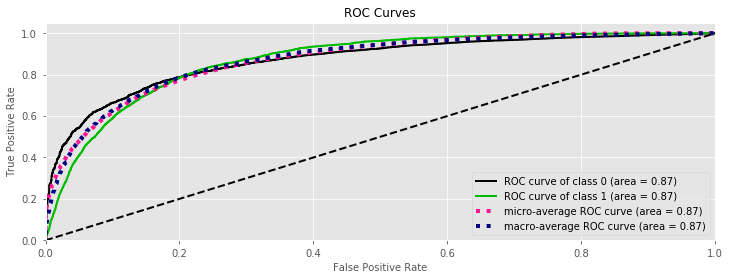

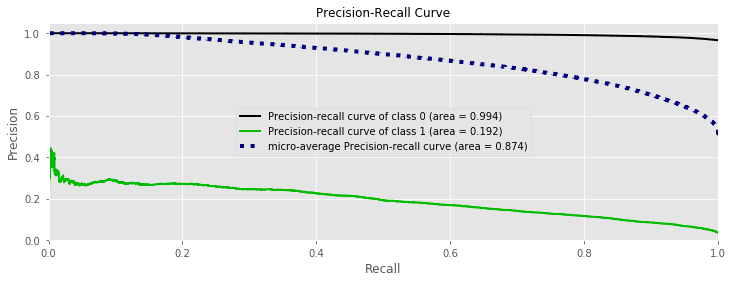

In [0]:
skplt.metrics.plot_roc(yout.test, y_proba)
skplt.metrics.plot_precision_recall(yout.test, y_proba)

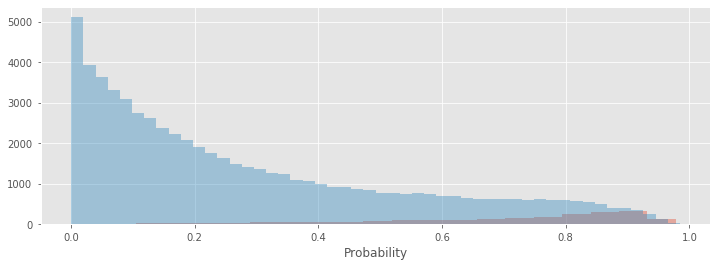

In [0]:
sns.distplot(yout[yout.test == 1].Probability, kde = False)
sns.distplot(yout[yout.test == 0].Probability, kde = False)
plt.show()

In [0]:
import shap

shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_xgb_2)
shap_values = explainer.shap_values(test_X_lr)

# visualize the first 100 prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[:100,:], test_X_lr.iloc[:100,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


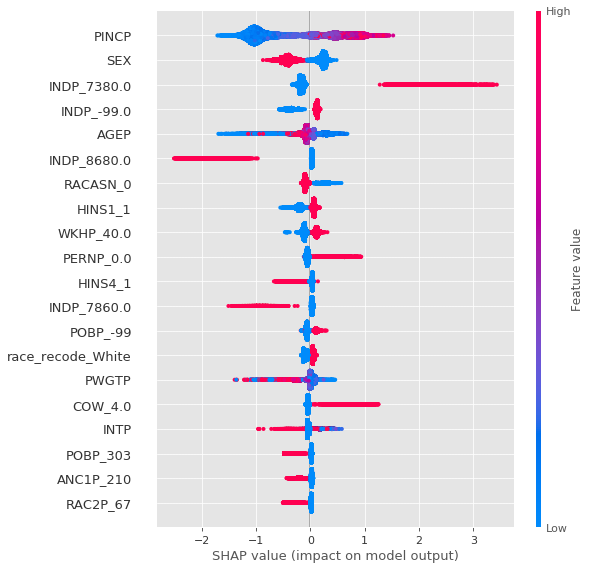

In [0]:
shap.summary_plot(shap_values, test_X_lr)

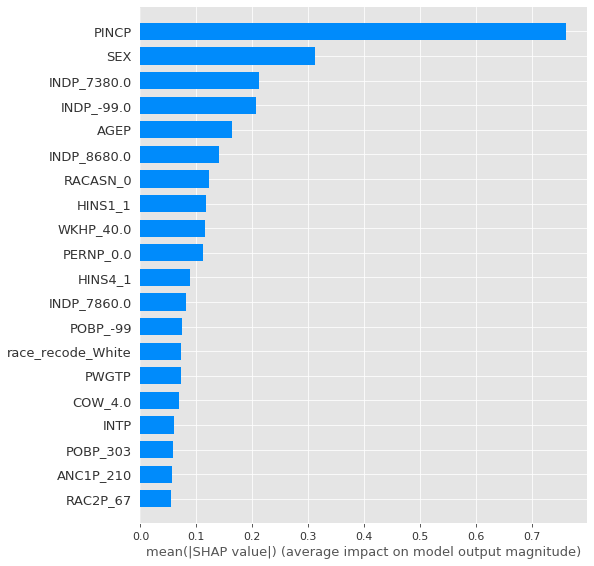

In [0]:
shap.summary_plot(shap_values, test_X_lr, plot_type="bar")

In [0]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X_lr.iloc[0,:])